In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import torch
import neuralprocesses.torch as nps
import matplotlib.pyplot as plt
import amort_bnn
import gp_datasets
import tqdm.auto as tqdm
import lab as B

torch.set_default_dtype(torch.float64)

In [3]:
gpdg = gp_datasets.GPDataGenerator()
num_tasks = 100
tasks = [gpdg.generate_task(range=[-3.0, 3.0]) for i in range(num_tasks)]

/home/troch/venvs/amort-inf-bnn-env/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


### Construct and train the amortised BNN

Epoch: 100%|██████████| 1000/1000 [00:48<00:00, 20.72it/s, loss=tensor(21.5577, grad_fn=<NegBackward0>), ll=tensor(23.7511, grad_fn=<MeanBackward0>), kl=tensor(45.3088, grad_fn=<MeanBackward0>)]


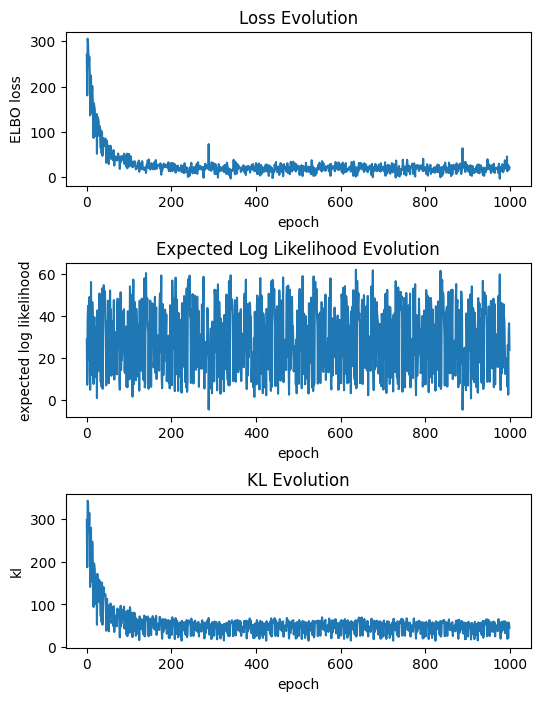

In [4]:
amort_bnn_model = amort_bnn.AmortNetwork(
    1,
    [50, 50],
    1,
)

opt = torch.optim.Adam(amort_bnn_model.parameters(), lr=1e-2)

loss_evo = []
ll_evo = []
kl_evo = []

epoch_iter = tqdm.tqdm(range(1000), "Epoch")
for i, epoch in enumerate(epoch_iter):
    
    task = tasks[i%num_tasks]
    
    opt.zero_grad()

    loss, ll, kl, noise = amort_bnn_model.elbo_loss(
        task['x_context'].unsqueeze(1), task['y_context'].unsqueeze(1), num_samples=1
    )
    loss_evo.append(loss.item())
    ll_evo.append(ll.item())
    kl_evo.append(kl.item())

    loss.backward()
    opt.step()
    
    epoch_iter.set_postfix({"loss": loss, "ll": ll, "kl": kl})
    
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(6, 8)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(loss_evo)
axs[0].set_ylabel("ELBO loss")
axs[0].set_xlabel("epoch")
axs[0].set_title("Loss Evolution")

axs[1].plot(ll_evo)
axs[1].set_ylabel("expected log likelihood")
axs[1].set_xlabel("epoch")
axs[1].set_title("Expected Log Likelihood Evolution")

axs[2].plot(kl_evo)
axs[2].set_ylabel("kl")
axs[2].set_xlabel("epoch")
axs[2].set_title("KL Evolution")

plt.show()

In [43]:
np = nps.construct_gnp( 
    num_enc_layers=2,
    enc_same=True,
    num_dec_layers=3,
    width=50
    )

encoder_params = [param for module in np.encoder.links for param in module.parameters()]
decoder_params = [param for module in np.decoder.links for param in module.parameters()]
params = encoder_params + decoder_params
opt = torch.optim.Adam(params, lr=1e-2)

loss_evo = []

epoch_iter = tqdm.tqdm(range(1000), "Epoch")
for i, epoch in enumerate(epoch_iter):
    
    task = tasks[i%num_tasks]
    
    opt.zero_grad()

    loss = nps.elbo(
        np,
        zip(task['x_context'].unsqueeze(1), task['y_context'].unsqueeze(1)),
        task['x_target'].unsqueeze(1),
        task['y_target'].unsqueeze(1),
    )[1]
    loss_evo.append(loss.item())

    loss.backward()
    opt.step()
    
    epoch_iter.set_postfix({"loss": loss, "ll": ll, "kl": kl})

plt.plot(loss_evo)
plt.ylabel("ELBO loss")
plt.xlabel("epoch")
plt.title("Loss Evolution")

plt.show()

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]


NotFoundLookupError: For function "elbo", signature Signature(torch._C.Generator, neuralprocesses.torch.Model, builtins.zip, torch.Tensor, torch.Tensor) could not be resolved.